In [1]:
import re
from getpass import getpass

In [2]:
consumer_key = getpass('consumer_key')
consumer_secret = getpass('consumer_secret')
access_token = getpass('access_token')
access_token_secret = getpass('access_token_secret')

consumer_key········
consumer_secret········
access_token········
access_token_secret········


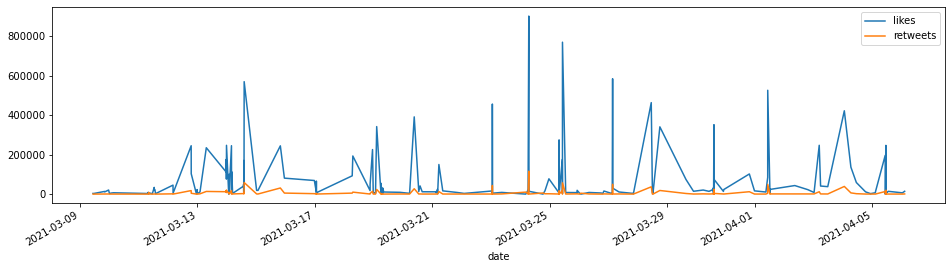

                                               tweets                   id  \
0   @CathieDWood @wintonARK @ARKInvest What do you...  1379258463386284038   
1   @ID_AA_Carmack Some kind of ELO level, updated...  1379229987115515907   
2         @Thomas38697956 New &amp; improved version!  1379055622042353667   
3   @Teslarati @ResidentSponge Special mention of ...  1379033568882663426   
4                                          @shbzz Obv  1379031412288974852   
5   @Teslarati @ResidentSponge Great work by Tesla...  1379031071732416514   
6                                       @EvaFoxU Nice  1379027422423695363   
7   The Earth is not flat, it’s a hollow globe &am...  1379026401341419520   
8   @EvaFoxU Those two really could have come in h...  1379023352480866304   
9                    @EvaFoxU Last Kingdom vs Vikings  1379022958157512705   
10  @spacex360 Ascent phase, transition to horizon...  1379022709737275393   
11  RT @SpaceX: Dragon is go for the first-ever po...  137901820

In [16]:

from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

from textblob import TextBlob
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        return auth

class TwitterStreamer():
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        stream.filter(track=hash_tag_list)

class TwitterListener(StreamListener):
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            return False
        print(status)


class TweetAnalyzer():
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1

    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

 
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="elonmusk", count=200)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    
    time_likes = pd.Series(data=df['likes'].values, index=df['date'])
    time_likes.plot(figsize=(16,4), label='likes', legend=True)
    
    time_likes = pd.Series(data=df['retweets'].values, index=df['date'])
    time_likes.plot(figsize=(16,4), label='retweets', legend=True)
    
    plt.show()

    print(df.head(20))